# IS4303 IT-MEDIATED FINANCIAL SOLUTIONS AND PLATFORMS
## Homework 2 - Overfitting, Regularization and Cross Validation
### Due Date: Mar. 6 (Sat.), 2021, 23:00 SG Time
### Name your .ipynb file as "StudentID_YourName_HW1.ipynb" and then upload

<div class="alert alert-warning">
<b>Python Version:</b> 3.7+<br>Create a virtual environment in Anaconda if needed.
</div>

## Sections
<ul>
    <li><a href="#Section_0" style="text-decoration: none">0. Assignment Overview</a></li>
    <li><a href="#Section_1" style="text-decoration: none">1. Data Preparation</a></li>
    <li><a href="#Section_2" style="text-decoration: none">2. Overfitting</a></li>
    <li><a href="#Section_3" style="text-decoration: none">3. Regularization</a></li>
    <li><a href="#Section_4" style="text-decoration: none">4. Cross-Validation</a></li>
</ul>

<a id="Section_0"></a>
## 0 Assignment Overview

* The goal of this assignment is to understand (1) Overfitting (2) Regularization in regression (3) Cross-validation.
* In this assignment, we will build linear models using a loan dataset. 
* A dataset containing complete loan data for all loans issued has been uploaded on Luminus. It includes the current loan status (Current, Late, Fully Paid, etc.) and a large set of attributes for each customer. 
* The assignment will require you to use the dataset to build models to predict loan default.
* Please answer the questions and write the code / results in the empty cells.
* 69 pts in total

In [47]:
#!usr/bin/env python
#-*- coding:utf-8 -*-
from __future__ import division, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt, log
from collections import defaultdict
from IPython.display import HTML
%matplotlib inline

<a id="Section_1"></a>
## 1. Data Preparation (7.5 pts)

<a id="Section_1.1"></a>
### 1.1 Load the data (1.5 pts)
* Load the data set (0.5 pt)
* The column '*bad_loans*' in the dataset is the outcome variable *y* as the one in the homework 1
* Drop the column '*home_ownership_OWN*' from the data set to avoid multicollinearity although this is not necessary (0.5 pt)
* Show the names of the features in your dataset and print out how many features you have (excluding outcome variable) (0.5 pt)

<div class="alert alert-warning">
<b>Tip: </b>You may save the list of features as for example, '<I>feature_original</I>' that does not containing 'bad_loans'.
</div>

In [48]:
# 1. read the dataset 
loans = pd.read_csv('/Users/chandya/Desktop/IS4303/HW2/HW2LoanStatsDataset_2020Q3.csv')

# 2. drop the column named 'home_ownership_OWN' to avoid multicollinearity
loans = loans.drop(columns=['home_ownership_OWN'])
# 3. get the names of base features, define them by 'feature_original'.
feature_original = list(loans.columns)
# remove bad_loans from feature_original
feature_original.pop(21)
outcome = pd.DataFrame(loans['bad_loans'])
# 4. Show the names of the features in your dataset and print how many features you have
print("The features in dataset are:\n {}\n".format(feature_original))
print("The number of features in dataset are {}.".format(len(feature_original)))
loans = pd.DataFrame(loans)
loans.head()

The features in dataset are:
 ['acc_now_delinq', 'annual_inc', 'avg_cur_bal', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_2yrs', 'dti', 'emp_length', 'grade', 'inq_fi', 'int_rate', 'installment', 'last_pymnt_amnt', 'loan_amnt', 'mths_since_last_delinq', 'num_bc_tl', 'pct_tl_nvr_dlq', 'revol_util', 'tax_liens', 'total_acc', 'total_bal_ex_mort', 'home_ownership_MORTGAGE', 'home_ownership_RENT']

The number of features in dataset are 23.


,acc_now_delinq,annual_inc,avg_cur_bal,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,emp_length,grade,inq_fi,...,mths_since_last_delinq,num_bc_tl,pct_tl_nvr_dlq,revol_util,tax_liens,total_acc,total_bal_ex_mort,bad_loans,home_ownership_MORTGAGE,home_ownership_RENT
0,0.0,11.608245,2412.0,0.0,0.0,3.0,10.33,10.0,3,5.0,...,10.0,8.0,85.7,47.5,0.0,29.0,31350.0,0,1,0
1,0.0,10.778977,3124.0,0.0,0.0,0.0,26.23,10.0,3,2.0,...,80.0,10.0,96.2,17.4,0.0,27.0,28116.0,0,1,0
2,0.0,11.350418,12652.0,0.0,0.0,0.0,16.26,1.0,2,1.0,...,26.0,5.0,94.3,44.6,0.0,35.0,113864.0,0,0,1
3,0.0,11.461643,53891.0,0.0,0.0,0.0,9.21,10.0,2,0.0,...,49.0,5.0,75.0,23.3,0.0,16.0,15698.0,0,1,0
4,0.0,11.461643,5573.0,0.0,0.0,1.0,12.95,10.0,3,2.0,...,4.0,5.0,100.0,34.5,0.0,29.0,50159.0,0,1,0


<a id="section_1.2"></a>
### 1.2 Generate polynomial features  (5.5 pts)
In practice, to avoid under-fitting or non-separable problems for classification, one common approach is to extend the original features by generating polynomial features based on all or some of the raw features. For example, suppose we have two raw features $(x_0, x_1)$, we can extend the 2-dimensional feature space to a polynomial 6-dimensional feature space $(1, x_0, x_1, x_0^2, x_1^2, x_0x_1)$.    
  
* In this assignment, we generate polynomial features based on 16 raw features defined by variable "*features_ploly_base*". **You need to set the highest order (degree) of the polynomial features as 3 and do not contain constant feature 1. In addition, non-interactional features that are built based on only one feature for example $x_0^2$, $x_0^3$ and $x_1^3$ should be included**. For instance, given a raw 2-D feature space $(x_0, x_1)$, the required 3-degree polynomial extension is $(x_0, x_1, x_0x_1, x_0^2, x_1^2, x_0x_1^2,x_0^2x_1, x_0^3, x_1^3)$. You may consider function <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html" target="_blank" class="btn btn-success" role="button" style="text-decoration: none">PolynomialFeatures()</a> to do this (2 pts)  

* Use the original feature names to construct the names of generated polynomial features. For example, for two features $(age, weight)$ that need to be 2-order polynomially extended, you are required to have feature names as $(age, weight, ageweight,age^2, weight^2)$ but not others like $(x_0,x_1,x_0x_1,x_0^2,x_1^2)$. (1 pt)

* This assignment involves two data sets: one containing only **original features** and the other containing **extended polynomial features**. They are defined as follows. (2 pt)

 **original features** = features defined at [Section 1.1](#Section_1.1)  
 **$n$ generated polynomial features** are built on features_ploly_base, including *features_ploly_base* as well   
 **extended polynomial features** = $n$ generated polynomial features + 7 non-polynomial features (i.e., 23 **original features** - 16 *features_ploly_base*) 

* show how many columns and rows are in the new dataset. (0.5 pts)


<div class="alert alert-danger">
<b>Note:</b><p>You need to check whether there are unexpected Nan values generated during the operation of dataframe by command <I>YourDataframe.isna().sum()</I>.</p>
</div>

In [49]:
from sklearn.preprocessing import PolynomialFeatures

# The selected base features that we need to make polynomial extension on them. 
# Note that it does not necessary to have to include all the features we showed above
features_ploly_base=['annual_inc','chargeoff_within_12_mths','delinq_2yrs','dti','emp_length','grade',\
                     'home_ownership_MORTGAGE','home_ownership_RENT','inq_fi','int_rate','installment',\
                     'last_pymnt_amnt','loan_amnt','num_bc_tl','pct_tl_nvr_dlq','revol_util']

# 1. 3-order polynomial transformation on features_ploly_base
poly = PolynomialFeatures(3, include_bias=False)


# 2. transform data of generated polynomial features (list) to DataFrame
# set the name of polynomial features according to the original name in features_ploly_base
# by setting the 'columns' parameter to poly.get_feature_names(input_features = features_ploly_base)
loans_extended = loans[features_ploly_base]
loans_extended = pd.DataFrame(poly.fit_transform(loans_extended))
loans_extended.columns = poly.get_feature_names(features_ploly_base)
# 3. generate new data set that includes extended polynomial features + outcome variable
# You may remove features_ploly_base from the copy of feature_original
feature_original = list (set(feature_original) - set(features_ploly_base))
loans_non_poly = loans[feature_original]
loans_extended = loans_non_poly.join(loans_extended)
loans_extended = loans_extended.join(outcome)
# 4. show the column and row number of your new data set.

loans_extended.head()

print("The number of rows is {}".format(loans_extended.shape[0]))
print("The number of columns is {}".format(loans_extended.shape[1]))

The number of rows is 2373
The number of columns is 976


<a id="Section_1.3"></a>
### 1.3 Features and Outcome Variable Separation (0.5 pt)
Extract feature-related data as "X" and outcome variable related data as "y" away from "LoanData_new". This step is for data splitting in the following.  
X corresponding to data with all the extended polynomial features aforedefined, y corresponding to data with only 'bad_loans'

In [50]:
# Did not include bad_loans when generating the fitted data set in above question therefore just bringing it down here
X, y = loans_extended.drop('bad_loans', axis=1), loans_extended['bad_loans']

<a id="Section_2"></a>
## 2. Overfitting (30.5 pts)
This section aims to give you an understanding of overfitting. In this section, we set up the logistic model parameters of <a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html" target="_blank" class="btn btn-success" role="button" style="text-decoration: none">Logistic Regression</a> as follows:  
* class_weight='balanced',random_state=42,solver='liblinear', C=10\*\*10, max_iter=50000,tol=1e-9, and keep the intercept term in the objective function (0.5 pt)   
 * tip 1: You may save these parameter setting as a dictionary and use it to instantiate LogisticRegression() class
 * tip 2: Name the object of LogisticRegression() as an unified name, "lr_normal" 

<div class="alert alert-warning">
<b>Note: </b>The parameter "<I>C</I>" which is equal to $1/\lambda$ captures the degree of regularization: The larger "<I>C</I>" is, the lower the degree of regularization is. Here we set a large enough <I>C</I>=$10^{10}$ to remove regularization, i.e., normal logistic regression.
</div>

In [51]:
# Import libraries
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, accuracy_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import train_test_split, KFold

lr_normal = LogisticRegression(class_weight='balanced',random_state=42,solver='liblinear', C=10**10, max_iter=50000,tol=1e-9)

<a id="Section_2.1"></a>
### 2.1 Learning with original features only: lr_21 (15 pts)
In the subsection [2.1](#Section_2.1), [2.2](#Section_2.2) and [2.3](#Section_2.3), we will fit a model using the data with only **original features**  
* Split the data *X* and *y* obtained at [Section 1.3](#Section_1.3) under *train set: test set = 70/30* (0.5 pt)  
 * **Takeaway: a common strategy of splitting data in practice is train set: test set using = 70/30 or 80/20**
 * Fix *random_state*=42 for *train_test_split()* so that results could be replicated. Refer to <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html" target="_blank" class="btn btn-success" role="button" style="text-decoration: none">Data Splitting</a> for more information. 
 * tips: You may save the parameter of data splitting as a dictionary and use it in the subsequent data splitting procedure if at all

In [52]:
# Note: In this assignment, I denote data variables with base features by X_train_original and X_test_original,
#       denote data variables with extended polynomial features by X_train_poly and X_test_poly,
#       if you see them in the comments, please do not confuse about them

# split the data set:
# Save  'X_train_original' and 'X_test_original' containing only the original features

X_train_original, X_test_original = train_test_split(loans, 
                         train_size=0.70,
                         test_size=0.30, random_state=42)    
y_train_original = X_train_original['bad_loans']
y_test_original = X_test_original['bad_loans']
X_train_original = X_train_original.drop(columns=['bad_loans'])
X_test_original = X_test_original.drop(columns=['bad_loans'])

print(X_train_original.shape)                          
print(X_test_original.shape)                           

(1661, 23)
(712, 23)


* Train and test the model (3 pts)
    * Train the model using train set with only original features (0.5 pt)
    * Show the coefficients and intercept of the model (0.5 pt)
    * Make predictions on both train and test sets (1 pt)
    * Show the Accuracy of training and testing (1 pt)

In [53]:
# 1. Training step
print("Training step:")

clf = lr_normal.fit(X_train_original, y_train_original)
print("The intercept of model is: " + str (clf.intercept_))
print("The coefficients of the model are:\n {}\n".format(clf.coef_))
train_pred = clf.predict(X_train_original)
print("Accuracy of fitted model on train set is: " + str(accuracy_score(y_train_original, train_pred)))

# 2. Testing step
print("Testing step:")
test_pred = clf.predict(X_test_original)
print("Accuracy of fitted model test set is: " + str(accuracy_score(y_test_original, test_pred)))


Training step:
The intercept of model is: [-6.01237812]
The coefficients of the model are:
 [[ 0.00000000e+00 -1.42476860e-01  4.39714454e-06 -2.18355645e+00
   4.13205232e-01  8.62807376e-02  2.28467659e-02 -2.52498325e-02
   1.94045539e-01  3.57978779e-02  2.56396537e-02 -5.07099467e-04
  -4.49508497e-04  1.10268417e+00  3.54986484e-03 -3.75048102e-02
  -1.39309537e-02 -4.04673646e-03  0.00000000e+00 -2.24616550e-02
   5.91984749e-07 -1.74537149e-01 -4.25357199e-01]]

Accuracy of fitted model on train set is: 0.8332329921733895
Testing step:
Accuracy of fitted model test set is: 0.8230337078651685


* Given the performances of the logistic model above on the train and test sets, do you think there is over fitting problem? An answer is acceptable if you can reasonablly justify it (1 pt)  

In [54]:
## write your answer here
# There is no overfitting problem. The accuracy scores of training step and test step are 
# close to each other and there is not a huge discrepancy where model performs extremely well 
# with train set and bad with test set.

* Draw a ROC curve for the trained logistic regression model above on test set and show the corresponding AUC value (2 pts)

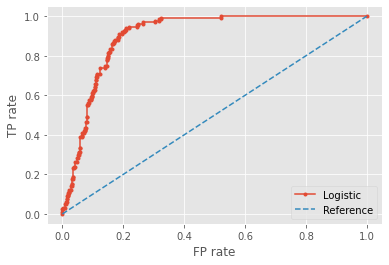

Logistic: ROC AUC=0.903


In [55]:
# Get predicted scores Pr(y=1): Used as thresholds for calculating TP Rate and FP Rate

# calculate roc curve
# predict probability:
lr_probs = clf.predict_proba(X_test_original)
# keep the 1s only:
lr_probs = lr_probs[:, 1]
# calculate scores:
lr_auc = roc_auc_score(y_test_original, lr_probs)
# Plot static ROC curve
lr_fpr, lr_tpr, thresholds = roc_curve(y_test_original, lr_probs)
ns_probs = [0 for _ in range(len(y_test_original))]
ns_auc = roc_auc_score(y_test_original, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test_original, ns_probs)
ns_fpr, ns_tpr, _ = roc_curve(y_test_original, ns_probs)
plt.xlabel('FP rate')
plt.ylabel('TP rate')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Reference')
plt.legend()
plt.show()


print('Logistic: ROC AUC=%.3f' % (lr_auc))

* What can you observe from this curve? Is the model acceptable? (1 pt)
* Provide some advantages of using ROC curve as compared to other metrics like precise rate? (2 pts)

In [56]:
## write your answer here
# The AUC value of this model is close to 1 (0.903). This indicates that the false positive rate is low and true positive rate is high.
# Therefore the model is acceptable.
# ROC curve allows you to visualise the tradeoff between sensitivity and specificity of the model rather that precision rate
# which only allows us to see the specificity. This gives a more accurate reflection of how good the model is.

* Per the trained model, try to answer the following three questions (3 pts): 
    * Which three of those features do you think have the most significant effect on the outcome variable? (1 pts)
    * Try to interpret the coefficient of any one of the three features? (1 pts)
    * Simply discuss why the coefficients of variable '*acc_now_delinq*' and '*tax_liens*' are both zero? (1 pts)

In [57]:
# Write your answer here
# The 3 features with the most significant effects on the outcome variables would be 
# "chargeoff_within_12_mths", "loan_amnt" and "home_ownership_RENT". These features have the biggest
# coefficient at modulus. Therefore they will have the biggest impact on the outcome variable as compared
# to the rest of the features be it negative or positive effect.

# chargeoff_within_12_mths has -2.18355645 coeffficient. This would mean that for one unit of this variable, it will decrease the outcome possibility by 2.18355645 times.

# Coefficient is the estimated change in the natural log of the odds when you change from the reference level to the level of the coefficient. The reason why
# these two variables have a coefficient of 0 may be because they do not have any variation within them. As seen in the data, acc_now_delinq is all 0.0 and tax_liens is all
# 0.0 as well, so model assumes they have no impact on outcome.


* Delete the two columns ('*acc_now_delinq*', '*tax_liens*') from the data and update the original feature list. We will not use these two features anymore (0.5 pt)

In [58]:
loans.drop(['acc_now_delinq','tax_liens'], axis=1, inplace=True)
loans_extended.drop(['acc_now_delinq','tax_liens'], axis=1, inplace=True)
feature_original.remove('acc_now_delinq')
feature_original.remove('tax_liens')
X_train_original.drop(['acc_now_delinq','tax_liens'], axis=1, inplace=True)
X_test_original.drop(['acc_now_delinq','tax_liens'], axis=1, inplace=True)

* Probit Model (2 pts)

Now, train a **Probit** model on the train set. You may use <a href="https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Probit.html" target="_blank" class="btn btn-success" role="button" style="text-decoration: none">probit model</a> for this. Set the parameters of fit() method as **start_params=None, method='newton', maxiter=1000, full_output=1, disp=1, callback=None** and sumarize the model by method *fitted_probit_model.summary()*. (3 pts)

In [59]:
from statsmodels.discrete.discrete_model import Probit

fitted_probit_model = Probit(y_train_original, X_train_original).fit(start_params=None, method='newton', maxiter=1000, full_output=1, disp=1, callback=None)
fitted_probit_model.summary()

Optimization terminated successfully.
         Current function value: 0.271905
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:              bad_loans   No. Observations:                 1661
Model:                         Probit   Df Residuals:                     1640
Method:                           MLE   Df Model:                           20
Date:                Mon, 15 Mar 2021   Pseudo R-squ.:                  0.4044
Time:                        21:13:20   Log-Likelihood:                -451.63
converged:                       True   LL-Null:                       -758.23
Covariance Type:            nonrobust   LLR p-value:                4.804e-117
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
annual_inc                    -0.2976      0.083     -3.582      0.000      -0.460      -0.135
avg_cur_bal                 2.862e-06   3.19e-06      0.896      0.370    -3.4e-06    9.12e-06
chargeoff_within_12_mths      -1.0778      0.617     -1.746      0.081      -2.287       0.132
collections_12_mths_ex_med     0.3320      0.330      1.006      0.315      -0.315       0.979
delinq_2yrs                    0.0262      0.044      0.592      0.554      -0.061       0.113
dti                            0.0072      0.005      1.442      0.149      -0.003       0.017
emp_length                    -0.0161      0.013     -1.277      0.202      -0.041       0.009
grade                          0.0715      0.117      0.613      0.540      -0.157       0.300
inq_fi                         0.0210      0.024      0.860      0.390      -0.027       0.069
int_rate                       0.0190      0.022      0.862      0.389      -0.024       0.062
installment                    0.0003      0.000      1.055      0.292      -0.000       0.001
last_pymnt_amnt               -0.0002   1.29e-05    -14.339      0.000      -0.000      -0.000
loan_amnt                      0.4402      0.105      4.200      0.000       0.235       0.646
mths_since_last_delinq         0.0021      0.003      0.813      0.416      -0.003       0.007
num_bc_tl                     -0.0176      0.015     -1.198      0.231      -0.046       0.011
pct_tl_nvr_dlq                -0.0121      0.005     -2.540      0.011      -0.021      -0.003
revol_util                    -0.0026      0.002     -1.259      0.208      -0.007       0.001
total_acc                     -0.0123      0.006     -2.051      0.040      -0.024      -0.001
total_bal_ex_mort           1.528e-06   1.25e-06      1.225      0.220   -9.16e-07    3.97e-06
home_ownership_MORTGAGE       -0.1433      0.154     -0.928      0.354      -0.446       0.159
home_ownership_RENT           -0.3283      0.156     -2.100      0.036      -0.635      -0.022
==============================================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

<a id="Section_2.2"></a>
### 2.2 Normal Learning: lr_22 (3.5 pts)
Now, assume the scenario in which you have only a little data at hand to train a model. 
* Change the data-splitting setup: train set: test set = 20/80 (0.5 pt)  
* Repeat the second step at [Section 2.1](#Section_2.1) with the updated data (in both features and volume) and additionally show the AUC of training and testing (2 pt)
* You may write a function for repeated use of calculating AUC

<div class="alert alert-danger">
<b>Note: </b>Keep the model setup unchanged as Section 2.1.
</div>

In [60]:
# a customized function of computing AUC values

def calculate_auc(X, y, model):
    # predict probability:
    lr_probs = model.predict_proba(X)
    # keep the 1s only:
    lr_probs = lr_probs[:, 1]
    # calculate scores:
    fp, tp, threshold = roc_curve(y, lr_probs)
    return auc(fp, tp)

* Train the model using train set with only (updated) original features and show the Accuracy and AUC of training and testing

In [61]:
# 1. Split the data:
X_train_22, X_test_22 = train_test_split(loans, 
                         train_size=0.20,
                         test_size=0.80, random_state=42)
y_train_22 = X_train_22['bad_loans']
y_test_22 = X_test_22['bad_loans']
X_train_22 = X_train_22.drop(columns=["bad_loans"])
X_test_22 = X_test_22.drop(columns=["bad_loans"])

# 2. Training step
print("Training step: \n")
# Accuracy

lr_22 = lr_normal.fit(X_train_22, y_train_22)
train_pred = lr_22.predict(X_train_22)
accuracy = accuracy_score(y_train_22, train_pred)
print("Accuracy of training step is: {}".format(accuracy))
      
print("The AUC value is: {}.\n".format(calculate_auc(X_train_22, y_train_22, lr_22)))

# 3. Testing step
print("Testing step: \n")
test_pred = lr_22.predict(X_test_22)
accuracy = accuracy_score(y_test_22, test_pred)
print("Accuracy of fitted model test set is: {}".format(accuracy))
print("The AUC value is: {}.\n".format(calculate_auc(X_test_22, y_test_22, lr_22)))

Training step: 

Accuracy of training step is: 0.8755274261603375
The AUC value is: 0.9488344458812428.

Testing step: 

Accuracy of fitted model test set is: 0.8214849921011058
The AUC value is: 0.8874898108825356.



* Given the performances of the logistic model above on the train and test sets, do you think there is over fitting problem? An answer is acceptable if you can reasonablly justify it (1 pt)  

In [62]:
## write your answer here
# There is no over-fitting problem. Test AUC and accuracy is close to train AUC and accuracy and high.

<a id="Section_2.3"></a>
### 2.3 Normal Learning: lr_23 (2.5 pts)
Now, assume you have very less data at hand to train a model. 
* change the data-splitting setup: train set: test set = 2/98. (0.5) 
* Repeat the second step at [Section 2.2](#Section_2.2) with the updated data (in volume) and additionally show the AUC of training and testing (1 pt)

<div class="alert alert-danger">
<b>Note: </b>Keep the model setup unchanged as Section 2.1.
</div>

In [63]:
# 1. split the data: train set  

X_train_volume, X_test_volume = train_test_split(loans, 
                         train_size=0.02,
                         test_size=0.98, random_state=42)
y_train_volume = X_train_volume['bad_loans']
y_test_volume = X_test_volume['bad_loans']
X_train_volume = X_train_volume.drop(columns=["bad_loans"])
X_test_volume = X_test_volume.drop(columns=["bad_loans"])


# 2. Training step
print("Training step: \n")
# Accuracy

lr_22 = lr_normal.fit(X_train_volume, y_train_volume)
train_pred = lr_22.predict(X_train_volume)
accuracy = accuracy_score(y_train_volume, train_pred)
print("Accuracy of training step is: {}".format(accuracy))
      
print("The AUC value is: {}.\n".format(calculate_auc(X_train_volume, y_train_volume, lr_22)))
# 3. testing step
print("Testing step: \n")
test_pred = lr_22.predict(X_test_volume)
accuracy = accuracy_score(y_test_volume, test_pred)
print("Accuracy of fitted model test set is: {}".format(accuracy))
print("The AUC value is: {}.\n".format(calculate_auc(X_test_volume, y_test_volume, lr_22)))

Training step: 

Accuracy of training step is: 1.0
The AUC value is: 1.0.

Testing step: 

Accuracy of fitted model test set is: 0.8138435081685297
The AUC value is: 0.864013428369864.



* Given the performances of the logistic model above on the train and test sets, do you think there is over fitting problem? An answer is acceptable if you can reasonablly justify it (1 pt) 

In [64]:
## write your answer here
# There may be overfitting problem. The accuracy and AUC for training step performs perfectly, yielding a perfect 
# performance of 1.0. However the performance on test data is much lower by almost 0.2 times, even though
# performance on test is acceptable. The suspiciously perfect performance on training data
# indicates the possibility of overfitting.

<a id="Section_2.4"></a>
### 2.4 Extended Learning: lr_24 (2.5 pts)
In the subsection [2.4](#Section_2.4) and [2.5](#Section_2.5), we will fit our model using the data with **extended polynomial features**. Do the following steps:   
* Change the data-splitting setup: train set: test set = 20/80. (0.5 pts)  
* Repeat the second step at [Section 2.2](#Section_2.2) with the extended polynomial data (1 pt)

<div class="alert alert-danger">
<b>Note: </b>Keep the model setup unchanged as Section 2.1.
</div>

In [65]:
# 1. Split the data:
X_train_updated, X_test_updated, y_train_updated, y_test_updated = train_test_split(X, y, test_size=0.80, random_state=42)
#y_train_updated = X_train_updated['bad_loans']
#y_test_updated = X_test_updated['bad_loans']
#X_train_updated = X_train_updated.drop(columns=["bad_loans"])
#X_test_updated = X_test_updated.drop(columns=["bad_loans"])

# 2. Training step
print("Training step: \n")
# Accuracy

lr_22 = lr_normal.fit(X_train_updated, y_train_updated.values.ravel())
y_pred_24 = lr_22.predict(X_train_updated)
accuracy = accuracy_score(y_train_updated, y_pred_24)
print("Accuracy of training step is: {}".format(accuracy))
      
print("The AUC value is: {}.\n".format(calculate_auc(X_train_updated, y_train_updated, lr_22)))

# 3. Testing step
print("Testing step: \n")
y_pred_test = lr_22.predict(X_test_updated)
accuracy = accuracy_score(y_test_updated, y_pred_test)
print("Accuracy of fitted model test set is: {}".format(accuracy))
print("The AUC value is: {}.\n".format(calculate_auc(X_test_updated, y_test_updated, lr_22)))


Training step: 

Accuracy of training step is: 0.9957805907172996
The AUC value is: 1.0.

Testing step: 

Accuracy of fitted model test set is: 0.8278041074249605
The AUC value is: 0.8865034670914769.



* Given the performances of the logistic model above on the train and test sets, do you think there is over fitting problem? An answer is acceptable if you can reasonablly justify it (1 pt) 

In [66]:
## write your answer here
# There is an overfitting problem because the performance of the model on the training step is close to 
# perfect while the performance on test data is almost 20% lower therefore there might be a 
# slight overfitting problem but nothing too significant as the performance on the test data is 
# still in an acceptable level.


<a id="Section_2.5"></a>
### 2.5 Extended Learning: lr_25 (2.5 pts)
* Relax the tolerance of fitting objective function setup: *tol*=1e-4. (0.5 pt)
* Keep the data-splitting setup unchanged as [Section 2.4](#Section_2.4).
* Repeat the second step at [Section 2.2](#Section_2.2) with the extended polynomial data (1 pt)

<div class="alert alert-danger">
<b>Note: </b>Keep the model setup unchanged as Section 2.1 except for '<I>tol</I>'=1e-4.
</div>

In [67]:
# 1. change the tol for the model setup

lr_relax = LogisticRegression(class_weight='balanced',random_state=42,solver='liblinear', C=10**10, max_iter=50000,tol=1e-4)


# 2. Training step
print("Training step: \n")
# Accuracy

lr_22 = lr_relax.fit(X_train_updated, y_train_updated.values.ravel())
train_pred = lr_22.predict(X_train_updated)
accuracy = accuracy_score(y_train_updated, train_pred)
print("Accuracy of training step is: {}".format(accuracy))
      
print("The AUC value is: {}.\n".format(calculate_auc(X_train_updated, y_train_updated, lr_22)))

# 3. Testing step
print("Testing step: \n")
test_pred = lr_22.predict(X_test_updated)
accuracy = accuracy_score(y_test_updated, test_pred)
print("Accuracy of fitted model test set is: {}".format(accuracy))
print("The AUC value is: {}.\n".format(calculate_auc(X_test_updated, y_test_updated, lr_22)))


Training step: 

Accuracy of training step is: 0.8459915611814346
The AUC value is: 0.9045538741131655.

Testing step: 

Accuracy of fitted model test set is: 0.8256977356503423
The AUC value is: 0.902411517517838.



* Given the performances of the logistic model above on the train and test sets, do you think there is over fitting problem? An answer is acceptable if you can reasonablly justify it (1 pt) 

In [68]:
## write your answer here
# There is no overfitting in this performance. The performance on test data is on an acceptable level
# and the discrepancies between perfomance on training data and test data is minimal.

<a id="Section_2.6"></a>
### 2.6 Summary (4 pts)
Suggest some reasons for overfitting after our experiments (4 pts) 

In [69]:
## write your answer here
# 1. Model complexity: Train set overfitting attempts to fit signal but ends up fitting noise. This may be caused
# by have very little training data like as in Section 2.3 where the training data is only 0.02 of the loan data,
# which also incidently has the worst overfitting possibility compared to the other 3 sections.
# 2. If the highest order (degree) set in the polynomial function is too high, it may cause overfitting
# as it will start capturing the noise in the data and will not capture an accurate pattern,
# and hence fail to generalize on unseen data.
# 3. If the tolerance is too high, the algorithm will stop before it converges to find the optimal coefficients
# and will capture a lot of noise and unimportant features may be given too high of a coefficient hence resulting in
# overfitting.
# 4. By having a 0.2:0.8 split as opposed to the recommended 70/30 or 80/20 splits the data might not be enough for model to interpret a pattern.

<a id="Section_3"></a>
## 3. Regularization (26 pts)
This section aims to show how Regularization (i.e., Lasso and Ridge) works and how to tune them.  
We set up the parameters of *LogisticRegression()* for regularization as follows (0.5 pt):  
* Respectively set *penalty* of LogisticRegression() corresponding to *lasso* and *ridge* logistic regression (You may add this new element in the model setup dictionary you have created)
* Change *C=1e-6* for both lasso and ridge model setup
* To reduce computational load, we reset the tol=1e-5 (or 1e-4 if necessary) for lasso and ridge model 
* You may name the objects as "lr_lasso" and "lr_ridge" for LogisticRegression() 

<div class="alert alert-warning">
<b>Note: </b>Recall that the parameter "<I>C</I>" which is equal to $1/\lambda$ captures the degree of regularization: The larger "<I>C</I>" is, the lower the degree of regularization is. Here we set a <I>C</I>=$10^{-6}$ to strengthen regularization.
</div>

In [70]:
# update model setup parameters of LogisticRegression(): 'C' and 'tol' (0.5 pt)
lr_lasso = LogisticRegression(class_weight='balanced',random_state=42,solver='liblinear', C=1e-6, max_iter=50000,tol=1e-5)
lr_ridge = LogisticRegression(class_weight='balanced',random_state=42,solver='liblinear', C=1e-6, max_iter=50000,tol=1e-5)

<a id="Section_3.1"></a>
### 3.1. Lasso Logistic Regression: lr_lasso_31 (3.5 pts)  
For Lasso Regression, we need to set up *penalty* for *LogisticRegression()* in addition to '*C*' and '*tol*' we have done before  
* Use the data set with **extended polynomial features**
* Specify the "*penalty*" for lasso *LogisticRegression()* (0.5 pt)
* Change *C=1e-6* for both lasso model setup (0.5 pt)
* Relax the tolerance of fitting objective function setup: *tol*=1e-5 (0.5 pt)
* Keep the data-splitting setup unchanged as [Section 2.4](#Section_2.4)
* Repeat the second step at [Section 2.2](#Section_2.2) with the extended polynomial data and additionally show the intercept and coefficients of the model (1 pts)

In [71]:
# Add parameters 'penalty' for lasso. 
lr_lasso = lr_lasso.set_params(penalty = 'l1')

# 1. Set up lasso model by specifying the penalty


In [72]:
# 1. Training step
print("Training step:")

clf = lr_lasso.fit(X_train_updated, y_train_updated)
print("The intercept of model is: " + str (clf.intercept_))
print("The coefficients of the model are:\n {}\n".format(clf.coef_))
train_pred = clf.predict(X_train_updated)
print("Accuracy of fitted model on train set is: " + str(accuracy_score(y_train_updated, train_pred)))
print("The AUC value is: ", calculate_auc(X_train_updated, y_train_updated, clf))
# 2. Testing step
print("Testing step:")
test_pred = clf.predict(X_test_updated)
print("Accuracy of fitted model test set is: " + str(accuracy_score(y_test_updated, test_pred)))
print("The AUC value is: ", calculate_auc(X_test_updated, y_test_updated, clf))


Training step:
The intercept of model is: [0.]
The coefficients of the model are:
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.000000

The AUC value is:  0.8801703955424706


* Given the performances of the logistic model above on the train and test sets, do you think there is over fitting problem? An answer is acceptable if you can reasonablly justify it (1 pt) 

In [73]:
## write your answer here
# No overfitting. Performance on test data is above 0.8 hence acceptable and the discrepancy betweet
# performance on train data and test data is minimal which means the pattern has been accurately detected.

<a id="Section_3.2"></a>
### 3.2. Ridge Logistic Regression: lr_ridge_32 (2.5 pts)  
For Ridge Regression, we need to reset up *penalty* for LogisticRegression() in addition to '*C*' and '*tol*' we have done before
* Keep same setup as [Section 3.1](#Section_3.1) except for "*penalty*". (0.5 pt)
* Repeat the second step at [Section 2.2](#Section_2.2) with the extended polynomial data and additionally show the intercept and coefficients of the model (1 pts)

In [74]:
# change parameters: 'penalty' for ridge, this is not necessary if you do not use a dictionary variable for model seting up 

lr_ridge = lr_ridge.set_params(penalty = 'l2')
# 1. Set up ridge model by specify the penalty


In [75]:
lr_22 = lr_ridge.fit(X_train_updated, y_train_updated.values.ravel())

print("The intercept of model is: " + str (lr_22.intercept_))
print("The coefficients of the model are:\n {}\n".format(lr_22.coef_))
# 2. Training step
print("Training step: \n")
# Accuracy
train_pred = lr_22.predict(X_train_updated)
accuracy = accuracy_score(y_train_updated, train_pred)
print("Accuracy of training step is: {}".format(accuracy))
      
print("The AUC value is: {}.\n".format(calculate_auc(X_train_updated, y_train_updated, lr_22)))

# 3. Testing step
print("Testing step: \n")
test_pred = lr_22.predict(X_test_updated)
accuracy = accuracy_score(y_test_updated, test_pred)
print("Accuracy of fitted model test set is: {}".format(accuracy))
print("The AUC value is: {}.\n".format(calculate_auc(X_test_updated, y_test_updated, lr_22)))


The intercept of model is: [2.91468641e-16]
The coefficients of the model are:
 [[ 6.75001750e-15  6.30785890e-18  1.27934850e-11  1.01896562e-14
   0.00000000e+00  4.53591819e-12  0.00000000e+00  3.19906249e-15
  -1.73252641e-18  1.72537148e-16  5.71552722e-15  1.19090369e-15
   7.96750188e-16  1.89800498e-16  9.55827382e-17  3.58769943e-16
   4.67173775e-15  8.73560596e-14  5.41667142e-14  2.63577471e-15
   1.70534338e-15  2.47498822e-14  9.47748236e-15  3.51621858e-14
  -1.91185150e-17  1.88216602e-15  6.24461922e-14  1.32225175e-14
   8.69543078e-15  2.12668159e-15  1.01283686e-15  4.00518295e-15
   5.10784046e-14  9.46753625e-13  5.79224803e-13  2.89143062e-14
   1.89007432e-14  2.72743277e-13  1.05453115e-13 -1.73252641e-18
  -5.19800908e-18 -3.75964939e-17 -1.73209657e-18 -6.93010559e-18
  -1.73295632e-18  4.29913567e-22  1.28974860e-21 -3.99322613e-17
  -9.78005714e-16 -1.02560965e-15 -1.71589281e-17 -1.55953174e-17
  -1.49343561e-16 -1.22668372e-16  4.19985406e-16  3.24699129e

* Given the performances of the logistic model above on the train and test sets, do you think there is over fitting problem? An answer is acceptable if you can reasonablly justify it (1 pt) 

In [76]:
## write your answer here
# ## write your answer here
# No overfitting. Performance on test data is above 0.8 hence acceptable and the discrepancy betweet
# performance on train data and test data is minimal which means the pattern has been accurately detected.

### 3.3. Tune Regularization Regression (19.5 pts) 
You have understand how regularization works. However, you may wonder how much $C=1/\lambda$ should be. A natural way to find it is to use grid search for different *C* and find the best one.  
* Thus, we generate a set of $\lambda$'s and thereby a set of fitted models: (1 pt)
 * Let us generate $N=200 $ $\lambda$'s from $10^{-6}$ to $10^{5}$ for lasso and from $10^{-2}$ to $10^{25}$ for ridge. 
 * To do this, firstly generate N numbers from -2 to 25: for example $S=(-2,...,25)$
 * Then take $S$*th* power of 10 to get $N$ *C*'s
 * You may want to use numpy.logspace()
 * save the set of $\lambda$'s as a variable, say *lambda_list*
* To reduce computational load, set *tol*=1e-4 and *max_iter*=10000 for the following regularization regression (0.5 pt)
* You can reuse the two regularized model objects ("*lr_lasso*" and "*lr_ridge*") we have made at [Section 3.1](#Section_3.1) and [3.2](#Section_3.2) but only change the setting of *tol* and *max_iter*
* Keep the data-splitting setup unchanged as [Section 2.4](#Section_2.4)
* Save the coefficients of those models and the accuracy and the AUC of the $2N$ models on the **testing data** for every $\lambda$ in the set

In [77]:
# 1. generate the set of lambda (1 pt)
lambda_lasso = np.logspace(-6, 5, num=200, endpoint=True, base=10.0)
lambda_lasso = lambda_lasso.tolist()
lambda_ridge = np.logspace(-2, 25,num=200, endpoint=True, base=10.0)
lambda_ridge = lambda_ridge.tolist()
# 2. set tol=1e-4 and max_iter=10000 for lasso and ridge (0.5 pt)
lr_lasso.set_params(tol=1e-4)
lr_ridge.set_params(tol=1e-4)
lr_lasso.set_params(max_iter=10000)
lr_ridge.set_params(max_iter=10000)

LogisticRegression(C=1e-06, class_weight='balanced', max_iter=10000,
                   random_state=42, solver='liblinear')

<a id="Section_3.3.1"></a>
##### 3.3.1 Tune Lasso Logistic Regression (9 pts)
#### 3.3.1.1 Generate Lasso Coefficients (5 pts)

In [78]:
#  Save the coefficients of the N lasso models and the accuracy and the AUC of those models on the test set for every lambda (4 pts)
lasso_coefficient = []
lasso_accuracy = []
lasso_auc = []

for i in lambda_lasso:
    lr_lasso.set_params(C=1/i)
    lr_22 = lr_lasso.fit(X_train_updated, y_train_updated.values.ravel())
    lasso_coefficient.append(lr_22.coef_)
    y_pred = lr_22.predict(X_test_updated)
    lasso_accuracy.append(accuracy_score(y_test_updated, y_pred))
    lasso_auc.append(calculate_auc(X_test_updated, y_test_updated, lr_22))

<a id="Section_3.3.1.2"></a>
#### 3.3.1.2 Lasso Coefficients Trend (2 pts)
Plot the relationship between $\lambda$'s or $log(\lambda)$'s and lasso coefficients' size (1 pt). Report write your findings (1 pt).

<div class="alert alert-warning">
<b>Note: </b>Since there are multiple features, you need to draw curves as many as the number of features.  
    In addition you may try xscale('log') to scale the x-axis.
</div>

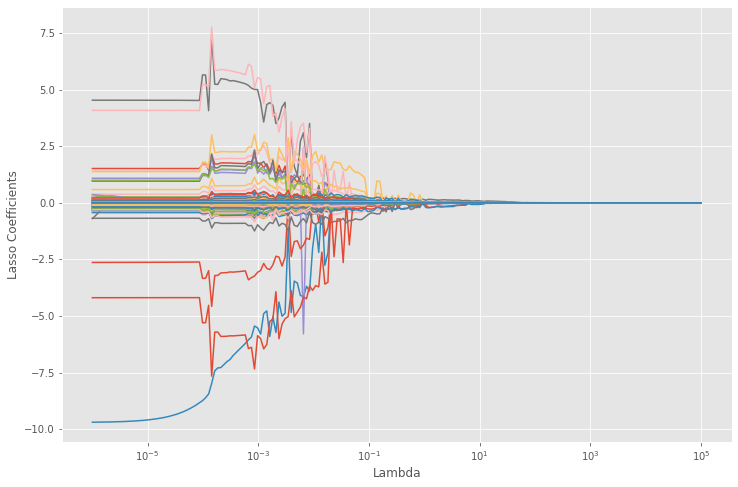

In [79]:
lasso_coef_narray = np.array(lasso_coefficient)
lasso_lambda = np.array(lambda_lasso)
lasso_coef_narray = lasso_coef_narray.reshape((200, X_train_updated.shape[1]))
plt.figure(figsize=(12,8))
plt.style.use('ggplot')
plt.plot(lasso_lambda,lasso_coef_narray)
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Lasso Coefficients')
plt.show()

In [80]:
# write your answer here
# Coefficients' absolute values decreases, hence their impact on
# outcome variable decreases. It finally converges to 0 at around 10^02 lambda.

<a id="Section_3.3.1.3"></a>
#### 3.3.1.3 Tune Lasso Logistic Regression parameter (2 pts)

* Plot the relationship between $\lambda$'s or $log(\lambda)$'s and lasso AUC (0.5 pt). What can you find (0.5 pt)? Report the best $\lambda$ and its corresponding AUC (1 pt)

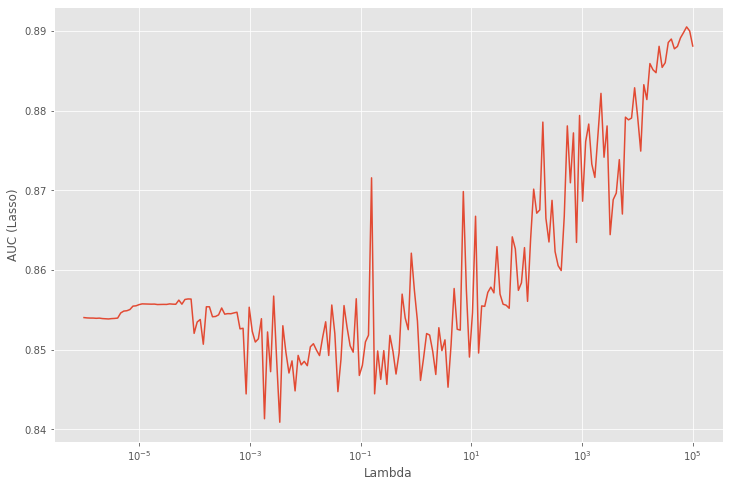

In [81]:
plt.figure(figsize=(12,8))
plt.style.use('ggplot')
plt.plot(lasso_lambda, lasso_auc)
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('AUC (Lasso)')
plt.show()

In [82]:
# write your answer here
# AUC generally increases as lambda increases.
# 

In [83]:
# select the best 𝜆 who provides best AUC and its corresponding AUC value
lasso_best_auc = max(lasso_auc)
best_index_lasso = lasso_auc.index(lasso_best_auc)
best_lambda_lasso = lasso_lambda[best_index_lasso]
print("The best lambda for lasso is: {}\n".format(best_lambda_lasso))
print("Its corresponding AUC value is: {}\n".format(lasso_best_auc))


The best lambda for lasso is: 77525.97488629464

Its corresponding AUC value is: 0.8905325884266515



<a id="Section_3.3.2"></a>
### 3.3.2 Tune Ridge Logistic Regression (9 pts)
#### 3.3.2.1 Generate Lasso Coefficients (5 pts)

In [84]:
#  Save the coefficients of the N ridge models and the accuracy, MSE and the AUC of those models on the test set for every lambda (4 pts)
ridge_coefficient = []
ridge_accuracy = []
ridge_auc = []

for i in lambda_ridge:
    lr_ridge.set_params(C=1/i)
    lr_22 = lr_ridge.fit(X_train_updated, y_train_updated.values.ravel())
    ridge_coefficient.append(lr_22.coef_)
    y_pred = lr_22.predict(X_test_updated)
    ridge_accuracy.append(accuracy_score(y_test_updated, y_pred))
    ridge_auc.append(calculate_auc(X_test_updated, y_test_updated, lr_22))

<a id="Section_3.3.2.2"></a>
#### 3.3.2.2 Ridge Coefficients Trend (2 pts)
Plot the relationship between $\lambda$'s or $log(\lambda)$'s and ridge coefficients' size. Then write your findings here.

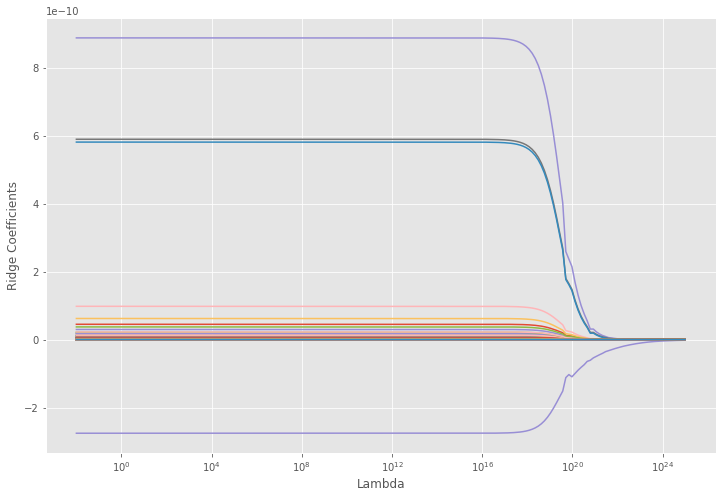

In [85]:
ridge_coef_narray = np.array(ridge_coefficient)
ridge_lambda = np.array(lambda_ridge)
ridge_coef_narray = ridge_coef_narray.reshape((200, X_train_updated.shape[1]))
plt.figure(figsize=(12,8))
plt.style.use('ggplot')
plt.plot(ridge_lambda,ridge_coef_narray)
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Ridge Coefficients')
plt.show()

In [86]:
# write your answer here
# Coefficients are stable till approximately 10^18. Then its absolute value decreases sharply till 10^24 where it converges to 0.
# 

<a id="Section_3.3.2.3"></a>
#### 3.3.2.3 Tune Ridge Logistic Regression parameter (2 pts)

* Plot the relationship between $\lambda$'s or $log(\lambda)$'s and Ridge AUC. Describe what you find?  Report the best $\lambda$ and its corresponding AUC.

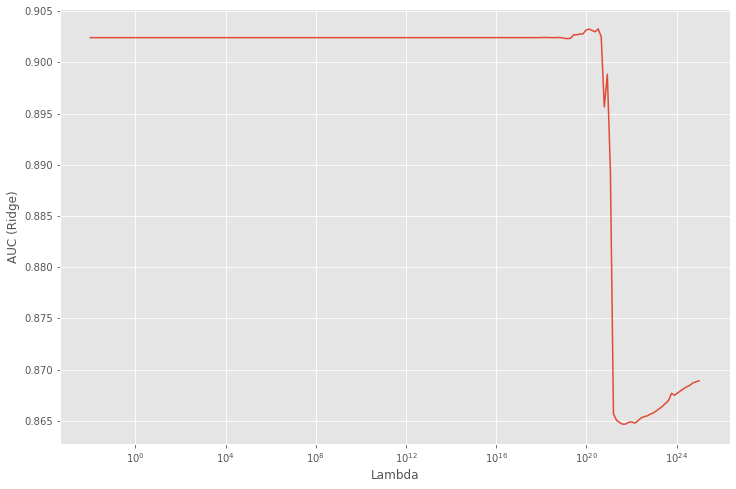

In [87]:
plt.figure(figsize=(12,8))
plt.style.use('ggplot')
plt.plot(ridge_lambda, ridge_auc)
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('AUC (Ridge)')
plt.show()

In [88]:
# write your answer here
# AUC is generally unaffected by lambda till approximately lambda 10^21, staying at a constant 0.903 (approximate). 
# It plunges steeply at lambda 10^21 but increases after that together with the lambda.

In [89]:
# select the best 𝜆 who provides best AUC and its corresponding AUC value
ridge_best_auc = max(ridge_auc)
best_index_ridge = ridge_auc.index(ridge_best_auc)
best_lambda_ridge = ridge_lambda[best_index_ridge]
print("The best lambda for ridge is: {}\n".format(best_lambda_ridge))
print("Its corresponding AUC value is: {}\n".format(ridge_best_auc))

The best lambda for ridge is: 3.331294787934684e+20

Its corresponding AUC value is: 0.9032675894874361



<a id="Section_4"></a>
## 4. Cross-Validation (5 pts)
In this section, we aim to exercise Cross-Validation  
<div class="alert alert-danger">
<b>Note: </b>In practice, we do cross-validation on train set and leave test set to test the model. Thus, the train set will be divided to two parts: one for training model and the other for validating the model. Then, after cross-validation, we test the model on test set. This is a common way of cross-validation.
</div>

* keep the data splitting unchanged as [Section 3.1](#Section_3.1).
* set **random_state=42** for *KFold()* so that your results can be replicated
* shuffle the data set (train set we used before) before k-fold splitting it. Check how to use model_selection.KFold() to do this
* Report the means of **5**-fold cross-validation accuracy scores of:  
 * logistic regression at [Section 2.5](#Section_2.5)
 * lasso logistic regression with best $C=1/\lambda$ selected at [Section 3.3.1.3](#Section_3.3.1.3)
 * ridge logistic regression with best $C=1/\lambda$ selected at [Section 3.3.2.3](#Section_3.3.2.3)


<div class="alert alert-warning">
<b>Note: </b>check how to use sklearn.model_selection.cross_val_score() at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
</div>

<div class="alert alert-danger">
<b>Note: </b>
<p>Usually Lasso/Ridge regression should improve model performance, but it is ok if your findings do not support it based on your results. Just report what you have discovered based on your results honestly. Please do not worry about whether you will get full marks or not.</p>
</div>
</div>

In [90]:
from sklearn.model_selection import KFold, cross_val_score
# build an object of 5-Fold Cross Validation 
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [91]:
# note that the whole data set has been divided into training set and testing set. 
# we only use the train set for cross-validation. Thus every data point in the training set is used k times while only one time in the test set
# Logistic regression (3 pts)
lr_22 = LogisticRegression(fit_intercept=True, solver='liblinear', C=10**10, max_iter=10000, tol=1e-4, random_state=42, class_weight= 'balanced')
accuracy_log = cross_val_score(lr_22, X_train_updated,y_train_updated.values.ravel(),cv=kf, scoring='accuracy')
# Lasso Regression
lasso = LogisticRegression(fit_intercept=True, penalty='l1', solver='liblinear', C=1/best_lambda_lasso, max_iter=10000, tol=1e-4, random_state=42, class_weight= 'balanced')
accuracy_lasso = cross_val_score(lasso, X_train_updated,y_train_updated.values.ravel(),cv=kf, scoring='accuracy')
# Ridge Regression
ridge = LogisticRegression(fit_intercept=True, penalty='l2', solver='liblinear', C=1/best_lambda_ridge, max_iter=10000, tol=1e-4, random_state=42, class_weight= 'balanced')
accuracy_ridge = cross_val_score(ridge, X_train_updated,y_train_updated.values.ravel(), cv=kf, scoring='accuracy')


In [46]:
# Model performance: Cross-validation (1.5 pts)
# Report average cross-validation accuracy of Logistic regression

print("Average cross validation accuracy of Logistic Regresstion is: {}\n".format(accuracy_log.mean()))
# Report average cross-validation accuracy of Lasso regression
print("Average cross validation accuracy of Lasso Regression is: {}\n".format(accuracy_lasso.mean()))


# Report average cross-validation accuracy of Ridge regression
print("Average cross validation accuracy of Ridge Regression is: ",accuracy_ridge.mean())


Average cross validation accuracy of Logistic Regresstion is: 0.8460022396416573

Average cross validation accuracy of Lasso Regression is: 0.8290929451287795

Average cross validation accuracy of Ridge Regression is:  0.8502127659574468
